# Scanpy

In [1]:
import pandas as pd
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import warnings

warnings.filterwarnings('ignore')

Import the transcripts CSV

In [2]:
# Add path to the Baysor ouput
output_path = 'data'
transcripts = pd.read_csv(os.path.join(output_path, 'transcripts.csv'))
transcripts

,transcript_id,x,y,z,qv,overlaps_nucleus,gene,cell
0,281590941166934,409.1653,32.8180,15.534491,40.000000,0,Plac8,NaN
1,281646775403050,405.6184,299.3480,19.096827,6.434603,0,Upp1,CR23a187f2b-217
2,281646775403080,412.1687,319.2710,22.834217,35.698690,1,Upp1,CR23a187f2b-82
3,281646775403103,418.6330,137.8801,22.487234,10.738749,1,Rcn3,CR23a187f2b-11
4,281646775403110,419.3826,216.8154,22.968016,40.000000,1,Btg1,CR23a187f2b-54
...,...,...,...,...,...,...,...,...
219998,281642480990917,296.0054,241.7324,17.995178,20.898504,0,Cxcl10,CR2194b25e4-3207
219999,281642480990981,302.6638,231.2954,16.426718,40.000000,0,H2-Ab1,CR2194b25e4-1186
220000,281642480991015,306.1975,385.7583,17.748650,40.000000,0,Itga6,CR2194b25e4-2133
220001,281642480991092,314.0051,247.1064,19.744427,7.941923,0,Il2rb,CR2194b25e4-1298


Create a cell x gene table

In [3]:

cross_tab = pd.crosstab(index=transcripts["cell"].values,
                        columns=transcripts['gene'].values)
cross_tab


col_0,Acta2,Adam12,Adam15,Adam17,Adam2,Adam23,Adam9,Adamdec1,Adgre1,Aicda,...,Vdr,Vim,Vps37b,Vtn,Vwf,Xcl1,Xcr1,Xist,Zdhhc14,Zp3
row_0,,,,,,,,,,,,,,,,,,,,,
CR2194b25e4-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CR2194b25e4-10,0,0,0,0,1,0,0,0,0,0,...,5,0,1,0,0,0,0,0,0,0
CR2194b25e4-100,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
CR2194b25e4-1000,1,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
CR2194b25e4-1001,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CR23a187f2b-95,1,0,1,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
CR23a187f2b-96,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CR23a187f2b-97,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


Get the spatial position of the cells. Here we just take the mean of x and y.

In [4]:
spatial = transcripts[~pd.isna(transcripts.cell)]
spatial = spatial.groupby("cell")[['x', 'y']].mean()
spatial = spatial.reindex(cross_tab.index)
spatial

,x,y
row_0,,
CR2194b25e4-1,34.683566,3.837232
CR2194b25e4-10,9.566888,52.007341
CR2194b25e4-100,125.559474,32.708719
CR2194b25e4-1000,354.151346,106.698660
CR2194b25e4-1001,244.296116,212.007103
...,...,...
CR23a187f2b-95,413.341232,344.193861
CR23a187f2b-96,408.984967,349.056542
CR23a187f2b-97,404.393609,351.167616


Put it together in an anndata object. This is also saved.

In [5]:
adata = ad.AnnData(
    X=cross_tab,
    obs=pd.DataFrame(
        index=cross_tab.index.values,
        data={
        'cell':cross_tab.index.values
    }),
    var=pd.DataFrame(
        index=cross_tab.columns,
        data={
            'gene':cross_tab.columns.values
        }
    )
)

adata.layers['raw'] = adata.X
adata.obsm['spatial'] = spatial.to_numpy()

adata.write("anndata.h5ad")

adata



AnnData object with n_obs × n_vars = 4438 × 350
    obs: 'cell'
    var: 'gene'
    obsm: 'spatial'
    layers: 'raw'

## Preprocessing

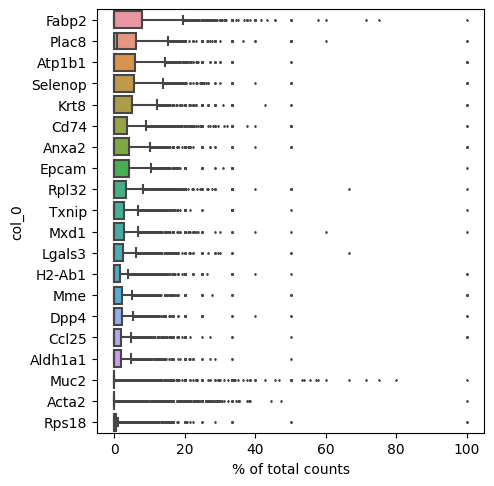

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Basic filtering

In [7]:
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

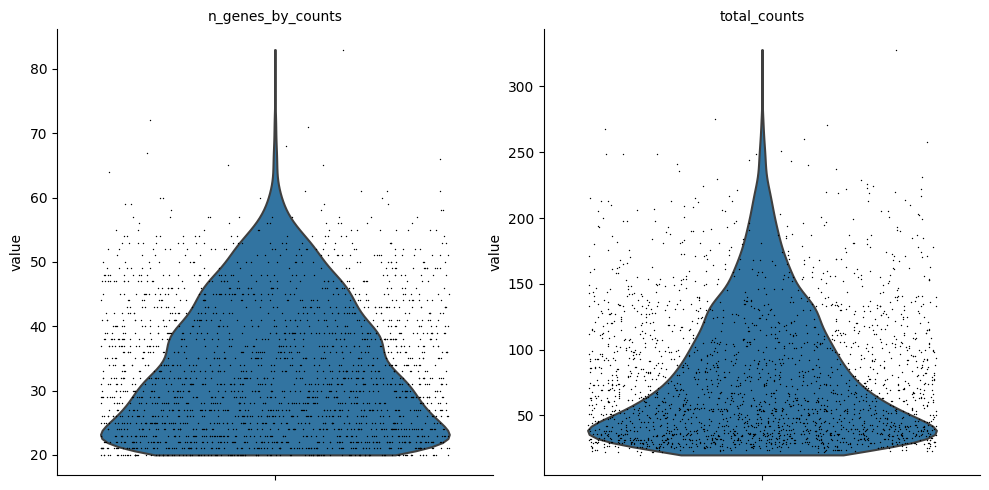

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)


In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [11]:
sc.pp.log1p(adata)

In [12]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

In [13]:
sc.tl.pca(adata, svd_solver='arpack')

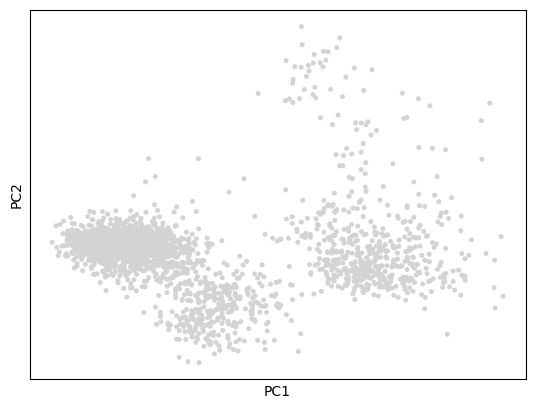

In [14]:
sc.pl.pca(adata)

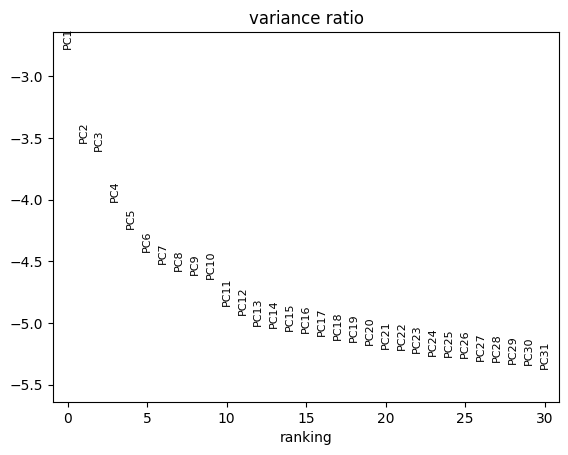

In [15]:
sc.pl.pca_variance_ratio(adata, log=True)

## Computing the neighborhood graph

In [16]:
sc.pp.neighbors(adata)

In [17]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

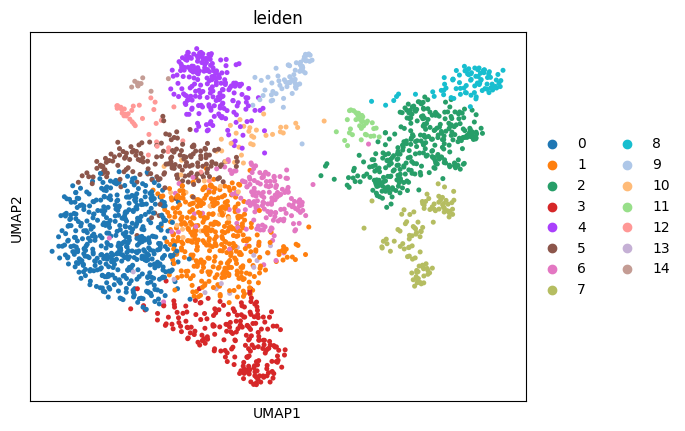

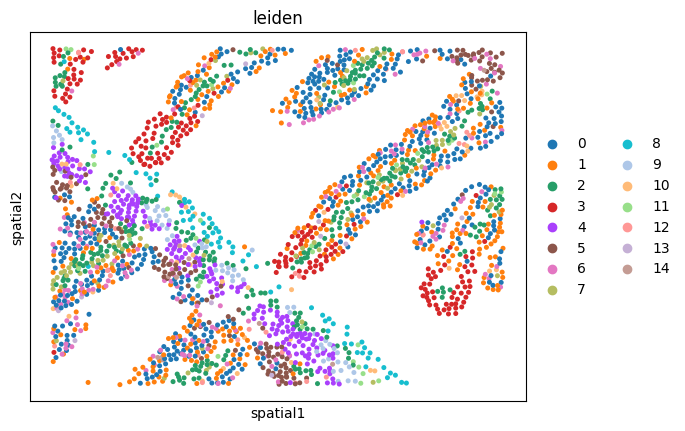

In [18]:
sc.pl.umap(adata, color=['leiden'])
sc.pl.embedding(adata, basis='spatial', color=['leiden'])

## Differential expression

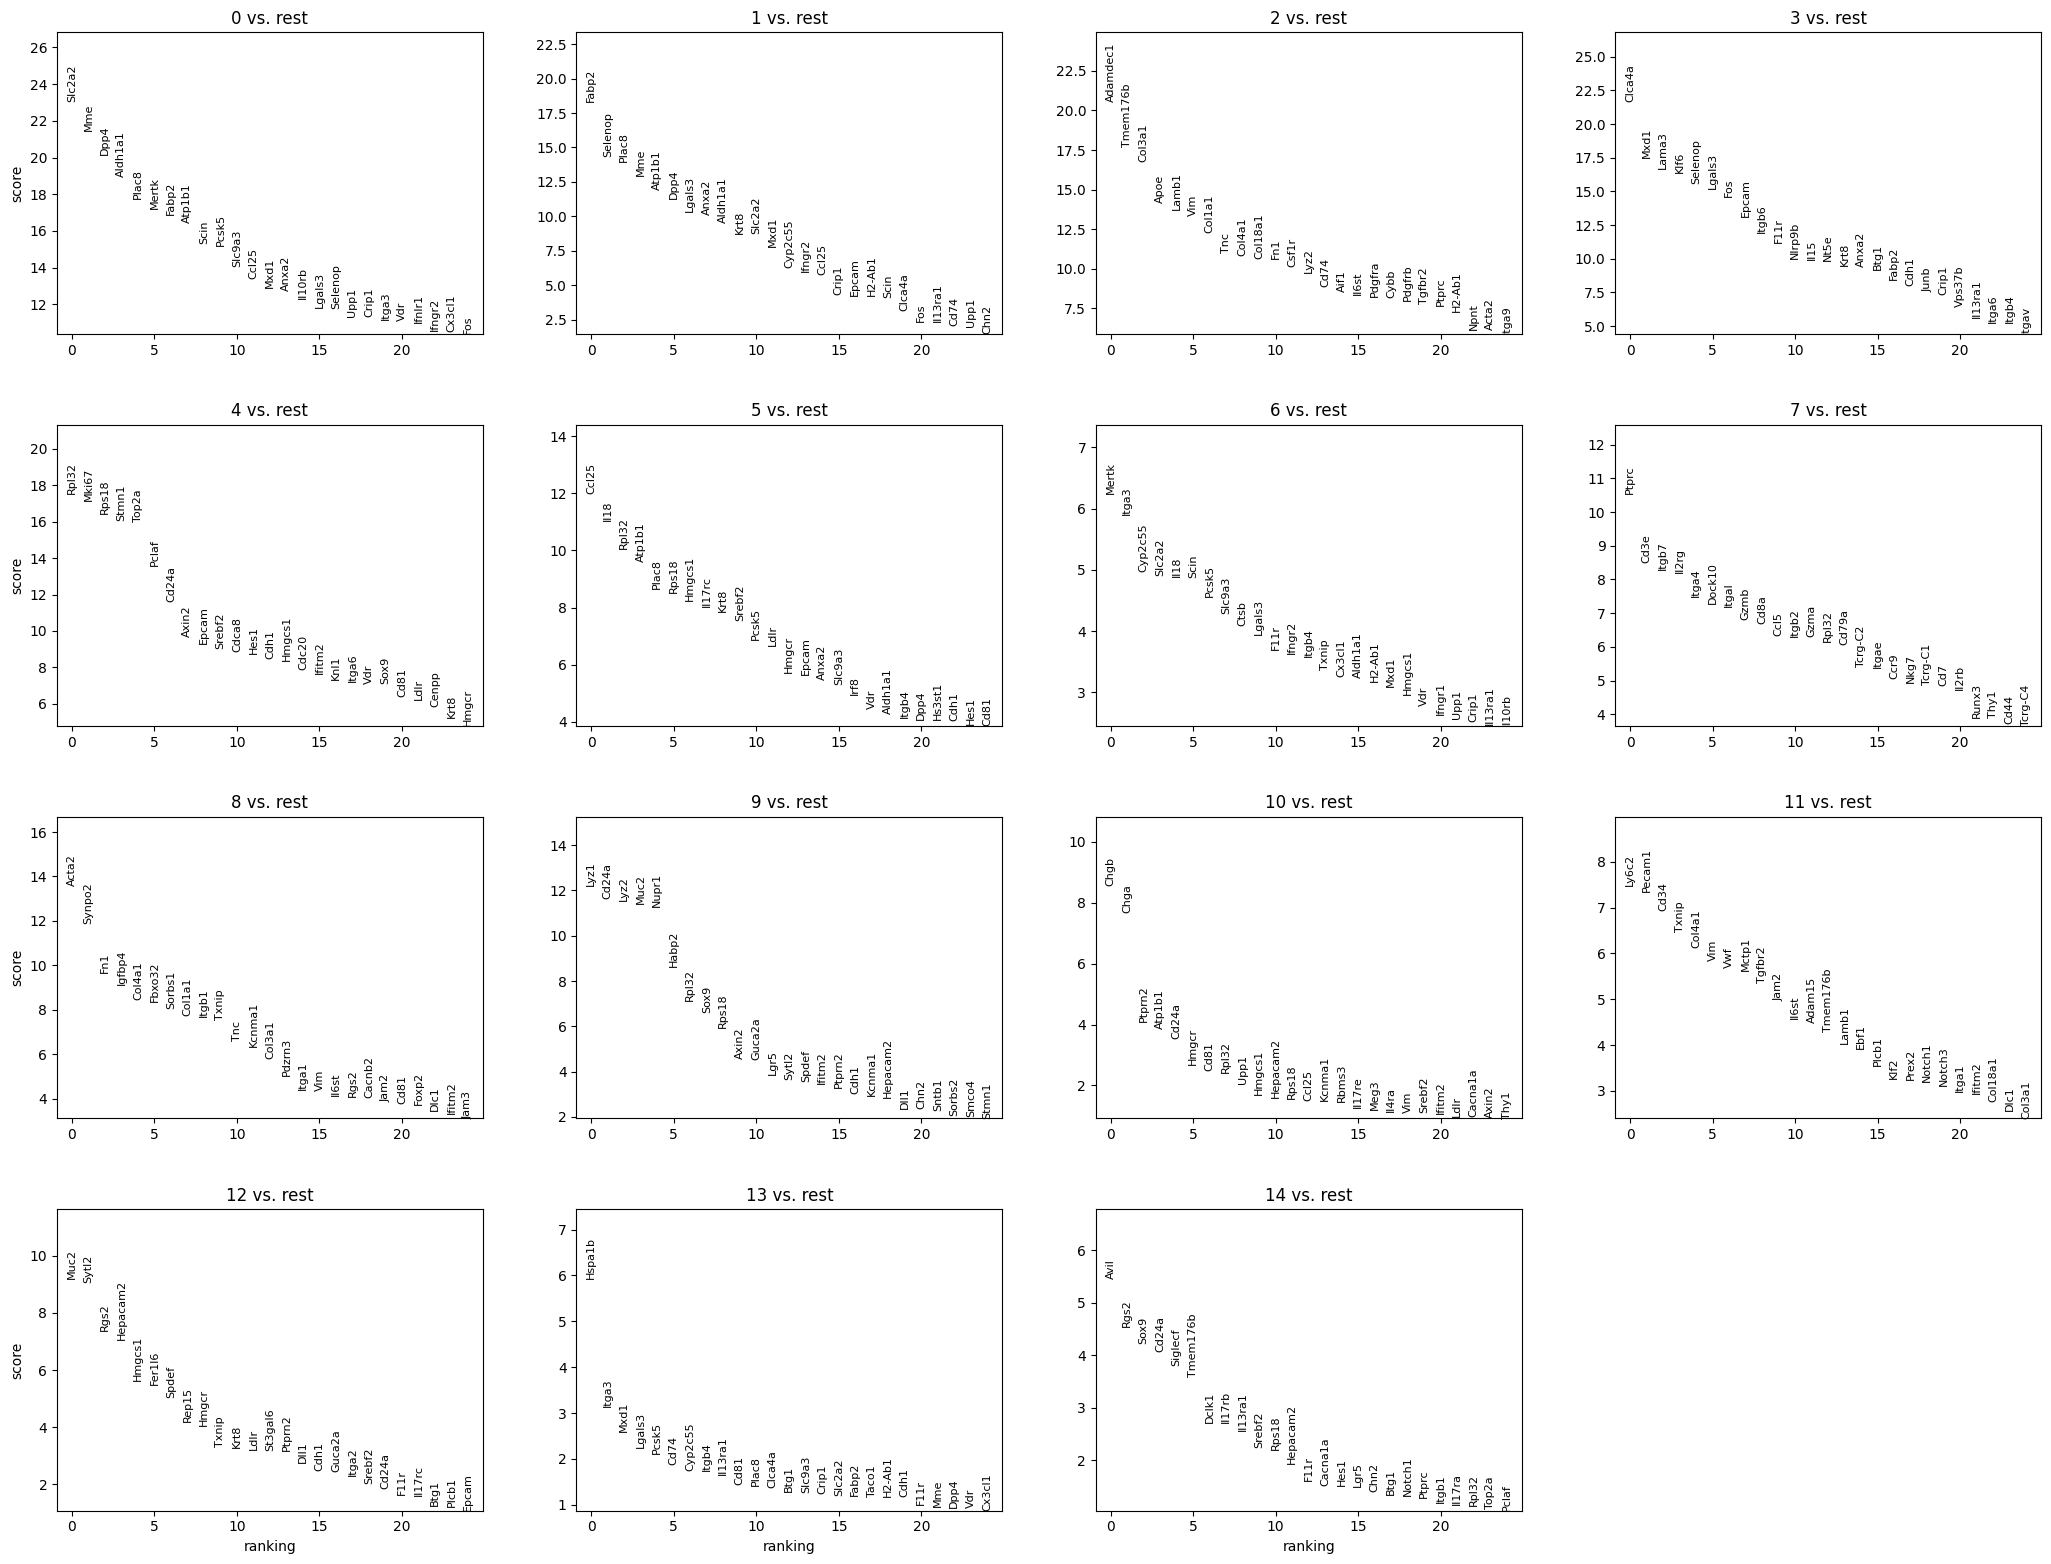

In [19]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [20]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Slc2a2,Fabp2,Adamdec1,Clca4a,Rpl32,Ccl25,Mertk,Ptprc,Acta2,Lyz1,Chgb,Ly6c2,Muc2,Hspa1b,Avil
1,Mme,Selenop,Tmem176b,Mxd1,Mki67,Il18,Itga3,Cd3e,Synpo2,Cd24a,Chga,Pecam1,Sytl2,Itga3,Rgs2
2,Dpp4,Plac8,Col3a1,Lama3,Rps18,Rpl32,Cyp2c55,Itgb7,Fn1,Lyz2,Ptprn2,Cd34,Rgs2,Mxd1,Sox9
3,Aldh1a1,Mme,Apoe,Klf6,Stmn1,Atp1b1,Slc2a2,Il2rg,Igfbp4,Muc2,Atp1b1,Txnip,Hepacam2,Lgals3,Cd24a
4,Plac8,Atp1b1,Lamb1,Selenop,Top2a,Plac8,Il18,Itga4,Col4a1,Nupr1,Cd24a,Col4a1,Hmgcs1,Pcsk5,Siglecf


In [21]:
marker_genes = np.unique(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5).to_numpy().flatten())

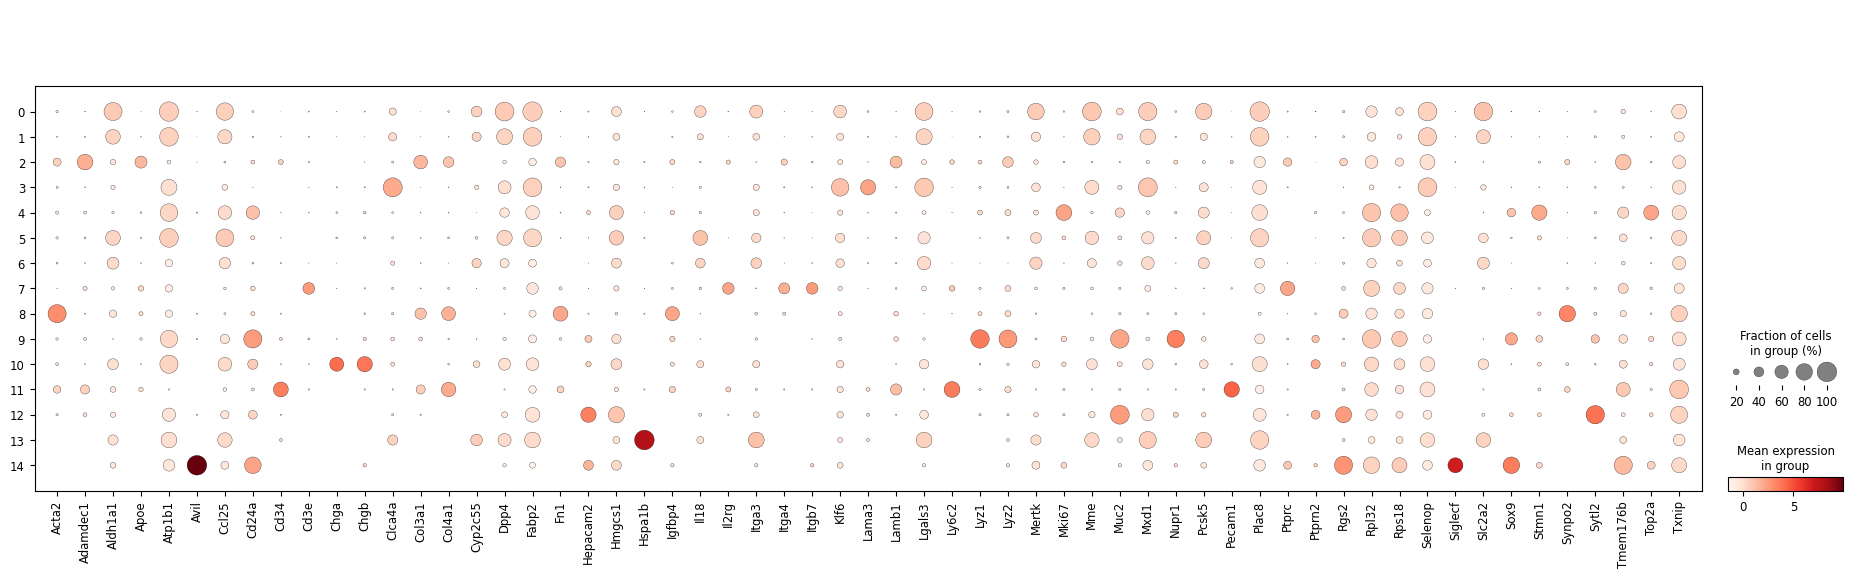

In [22]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');